# Bollinger Bands Mean Reversion Strategy: Deep Dive with Backtrader

**December 15, 2024 • Karthik Bibireddy (AI Generated Text)**

![Bollinger Bands Chart](https://images.unsplash.com/photo-1611974789855-9c2a0a7236a3?w=800&h=400&fit=crop)

## Overview

The Bollinger Bands Mean Reversion Strategy is a contrarian approach designed to profit from price returning to its statistical mean after reaching extreme overbought or oversold conditions. This strategy works exceptionally well in ranging markets and can generate consistent mid-term profits over 3-6 week periods when applied correctly.

This notebook provides a comprehensive deep dive using **backtrader**, a professional backtesting framework:
- Mathematical foundations of Bollinger Bands
- Strategy implementation using backtrader
- Real-world backtesting on multiple tickers
- Performance comparison: Baseline ETFs vs Individual Stocks
- Comprehensive visualizations for novice traders

## Table of Contents

1. [Setup and Imports](#setup)
2. [Mathematical Foundations](#mathematical-foundations)
3. [Understanding Bollinger Bands](#understanding-bb)
4. [Strategy Implementation with Backtrader](#strategy-implementation)
5. [Data Loading and Preparation](#data-loading)
6. [Backtesting on Baseline Tickers](#baseline-backtest)
7. [Performance Comparison](#performance-comparison)
8. [Visual Analysis](#visual-analysis)
9. [Key Takeaways](#key-takeaways)

## 1. Setup and Imports {#setup}

First, let's install and import all necessary libraries.

In [41]:
# Install backtrader if not already installed
# !pip install backtrader matplotlib pandas numpy

In [42]:
import backtrader as bt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 10

print("Backtrader version:", bt.__version__)
print("All libraries imported successfully!")

Backtrader version: 1.9.78.123
All libraries imported successfully!


## 2. Mathematical Foundations {#mathematical-foundations}

### Bollinger Bands Formula

Bollinger Bands consist of three components:

**Middle Band (MB)**:
$$MB_t = \frac{1}{n} \sum_{i=t-n+1}^{t} P_i$$

Where:
- $P_i$ = Price at period $i$
- $n$ = Number of periods (typically 20)
- $t$ = Current period

**Standard Deviation (σ)**:
$$\sigma_t = \sqrt{\frac{1}{n} \sum_{i=t-n+1}^{t} (P_i - MB_t)^2}$$

**Upper Band (UB)**:
$$UB_t = MB_t + (k \times \sigma_t)$$

**Lower Band (LB)**:
$$LB_t = MB_t - (k \times \sigma_t)$$

Where:
- $k$ = Standard deviation multiplier (typically 2.0)

### %B Indicator Formula

The %B indicator measures where price is relative to the bands:

$$\%B_t = \frac{P_t - LB_t}{UB_t - LB_t}$$

Interpretation:
- $\%B < 0$: Price below lower band (oversold)
- $0 \leq \%B \leq 1$: Price within bands
- $\%B > 1$: Price above upper band (overbought)

### Strategy Logic

**Oversold Signal (Long Entry)**:
- Price touches or penetrates lower Bollinger Band
- %B < 0
- RSI < 30 (oversold confirmation)

**Overbought Signal (Short Entry)**:
- Price touches or penetrates upper Bollinger Band
- %B > 1
- RSI > 70 (overbought confirmation)

**Exit Rules**:
- Target 1: Middle band (50% position)
- Target 2: Opposite band (remaining 50%)
- Stop Loss: 2-3% below/above band touch point

## 3. Understanding Bollinger Bands {#understanding-bb}

Let's visualize how Bollinger Bands work with a simple example:

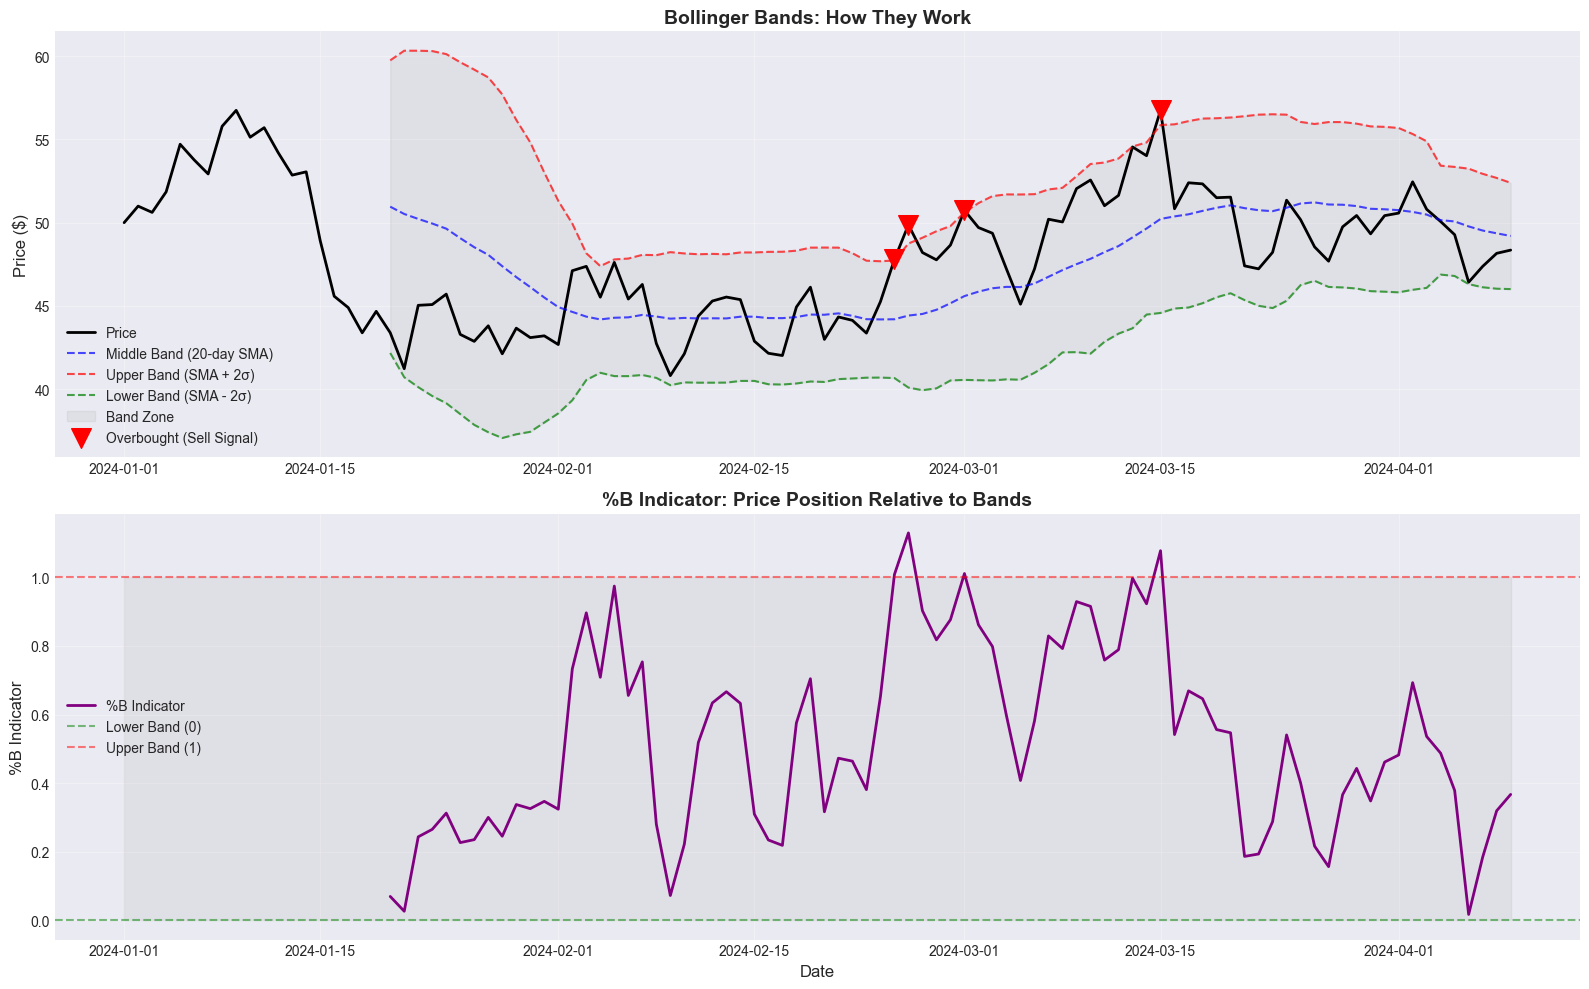

In [43]:
# Create a simple visualization to explain Bollinger Bands
def plot_bollinger_explanation():
    """Create an educational plot explaining Bollinger Bands."""
    fig, axes = plt.subplots(2, 1, figsize=(16, 10))
    
    # Generate sample price data
    np.random.seed(42)
    dates = pd.date_range(start='2024-01-01', periods=100, freq='D')
    base_price = 50
    prices = [base_price]
    
    for i in range(1, 100):
        change = np.random.normal(0, 2)
        mean_reversion = -0.1 * (prices[-1] - base_price)
        new_price = prices[-1] + change + mean_reversion
        prices.append(max(new_price, 30))
    
    df = pd.DataFrame({'date': dates, 'close': prices})
    
    # Calculate Bollinger Bands
    period = 20
    df['sma'] = df['close'].rolling(window=period).mean()
    df['std'] = df['close'].rolling(window=period).std()
    df['upper'] = df['sma'] + (2 * df['std'])
    df['lower'] = df['sma'] - (2 * df['std'])
    
    # Plot 1: Price and Bands
    ax1 = axes[0]
    ax1.plot(df['date'], df['close'], label='Price', linewidth=2, color='black')
    ax1.plot(df['date'], df['sma'], label='Middle Band (20-day SMA)', 
             linestyle='--', color='blue', alpha=0.7)
    ax1.plot(df['date'], df['upper'], label='Upper Band (SMA + 2σ)', 
             linestyle='--', color='red', alpha=0.7)
    ax1.plot(df['date'], df['lower'], label='Lower Band (SMA - 2σ)', 
             linestyle='--', color='green', alpha=0.7)
    
    # Fill between bands
    ax1.fill_between(df['date'], df['upper'], df['lower'], 
                     alpha=0.1, color='gray', label='Band Zone')
    
    # Mark oversold and overbought areas
    oversold_idx = df[df['close'] <= df['lower']].index
    overbought_idx = df[df['close'] >= df['upper']].index
    
    if len(oversold_idx) > 0:
        ax1.scatter(df.loc[oversold_idx, 'date'], df.loc[oversold_idx, 'close'], 
                   color='green', s=200, marker='^', label='Oversold (Buy Signal)', zorder=5)
    
    if len(overbought_idx) > 0:
        ax1.scatter(df.loc[overbought_idx, 'date'], df.loc[overbought_idx, 'close'], 
                   color='red', s=200, marker='v', label='Overbought (Sell Signal)', zorder=5)
    
    ax1.set_ylabel('Price ($)', fontsize=12)
    ax1.set_title('Bollinger Bands: How They Work', fontsize=14, fontweight='bold')
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: %B Indicator
    ax2 = axes[1]
    df['percent_b'] = (df['close'] - df['lower']) / (df['upper'] - df['lower'])
    ax2.plot(df['date'], df['percent_b'], label='%B Indicator', linewidth=2, color='purple')
    ax2.axhline(y=0, color='green', linestyle='--', alpha=0.5, label='Lower Band (0)')
    ax2.axhline(y=1, color='red', linestyle='--', alpha=0.5, label='Upper Band (1)')
    ax2.fill_between(df['date'], 0, 1, alpha=0.1, color='gray')
    ax2.set_ylabel('%B Indicator', fontsize=12)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_title('%B Indicator: Price Position Relative to Bands', fontsize=14, fontweight='bold')
    ax2.legend(loc='best')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

fig = plot_bollinger_explanation()
plt.show()

## 4. Strategy Implementation with Backtrader {#strategy-implementation}

Now let's implement the Bollinger Bands Mean Reversion Strategy using backtrader:

In [44]:
class BollingerBandsMeanReversion(bt.Strategy):
    """
    Bollinger Bands Mean Reversion Strategy
    
    Entry Rules:
    - Long: Price touches lower band + RSI < 30 + %B < 0
    - Short: Price touches upper band + RSI > 70 + %B > 1
    
    Exit Rules:
    - Target 1: Middle band (50% position)
    - Target 2: Opposite band (remaining 50%)
    - Stop Loss: 2.5% below/above entry
    """
    
    params = (
        ('bb_period', 20),      # Bollinger Bands period
        ('bb_devfactor', 2.0),  # Bollinger Bands standard deviation multiplier
        ('rsi_period', 14),     # RSI period
        ('rsi_oversold', 30),   # RSI oversold level
        ('rsi_overbought', 70), # RSI overbought level
        ('stop_loss_pct', 0.025), # Stop loss percentage (2.5%)
        ('printlog', False),    # Print trade logs
    )
    
    def __init__(self):
        # Bollinger Bands indicator
        self.bb = bt.indicators.BollingerBands(
            self.data.close,
            period=self.params.bb_period,
            devfactor=self.params.bb_devfactor
        )
        
        # RSI indicator
        self.rsi = bt.indicators.RSI(
            self.data.close,
            period=self.params.rsi_period
        )
        
        # Calculate %B indicator
        self.percent_b = (self.data.close - self.bb.lines.bot) / (self.bb.lines.top - self.bb.lines.bot)
        
        # Track orders and positions
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.sellprice = None
        self.sellcomm = None
        
        # Track partial exits
        self.target1_hit = False
        self.entry_price = None
        self.stop_loss_price = None
        self.target1_price = None
        self.target2_price = None
    
    def log(self, txt, dt=None):
        """Logging function."""
        if self.params.printlog:
            dt = dt or self.datas[0].datetime.date(0)
            print(f'{dt.isoformat()}: {txt}')
    
    def notify_order(self, order):
        """Execute when order status changes."""
        if order.status in [order.Submitted, order.Accepted]:
            return
        
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED, Price: {order.executed.price:.2f}, '
                        f'Cost: {order.executed.value:.2f}, Comm: {order.executed.comm:.2f}')
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:
                self.log(f'SELL EXECUTED, Price: {order.executed.price:.2f}, '
                        f'Cost: {order.executed.value:.2f}, Comm: {order.executed.comm:.2f}')
                self.sellprice = order.executed.price
                self.sellcomm = order.executed.comm
        
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
        
        self.order = None
    
    def notify_trade(self, trade):
        """Execute when trade is closed."""
        if not trade.isclosed:
            return
        
        self.log(f'OPERATION PROFIT, GROSS: {trade.pnl:.2f}, NET: {trade.pnlcomm:.2f}')
    
    def next(self):
        """Execute on each bar."""
        # Skip if indicators not ready
        if len(self.data) < max(self.params.bb_period, self.params.rsi_period):
            return
        
        # Get current values
        current_price = self.data.close[0]
        upper_band = self.bb.lines.top[0]
        lower_band = self.bb.lines.bot[0]
        middle_band = self.bb.lines.mid[0]
        rsi_value = self.rsi[0]
        percent_b_value = self.percent_b[0]
        
        # Skip if bands not calculated (NaN)
        if np.isnan(upper_band) or np.isnan(lower_band) or np.isnan(rsi_value):
            return
        
        # Check for exit conditions first
        if self.position:
            # Check stop loss
            if self.position.size > 0:  # Long position
                if current_price <= self.stop_loss_price:
                    self.log(f'STOP LOSS HIT (Long), Price: {current_price:.2f}')
                    self.close()
                    self._reset_targets()
                    return
                
                # Check target 1 (middle band) - close 50%
                if not self.target1_hit and current_price >= self.target1_price:
                    self.log(f'TARGET 1 HIT (Long), Price: {current_price:.2f}, Closing 50%')
                    size = int(self.position.size * 0.5)
                    if size > 0:
                        self.sell(size=size)
                        self.target1_hit = True
                
                # Check target 2 (upper band) - close remaining
                if self.target1_hit and current_price >= self.target2_price:
                    self.log(f'TARGET 2 HIT (Long), Price: {current_price:.2f}, Closing remaining')
                    self.close()
                    self._reset_targets()
                    return
            
            elif self.position.size < 0:  # Short position
                if current_price >= self.stop_loss_price:
                    self.log(f'STOP LOSS HIT (Short), Price: {current_price:.2f}')
                    self.close()
                    self._reset_targets()
                    return
                
                # Check target 1 (middle band) - close 50%
                if not self.target1_hit and current_price <= self.target1_price:
                    self.log(f'TARGET 1 HIT (Short), Price: {current_price:.2f}, Closing 50%')
                    size = int(abs(self.position.size) * 0.5)
                    if size > 0:
                        self.buy(size=size)
                        self.target1_hit = True
                
                # Check target 2 (lower band) - close remaining
                if self.target1_hit and current_price <= self.target2_price:
                    self.log(f'TARGET 2 HIT (Short), Price: {current_price:.2f}, Closing remaining')
                    self.close()
                    self._reset_targets()
                    return
        
        # Entry signals (only if no position)
        if not self.position:
            # Long entry: Oversold condition
            if (current_price <= lower_band * 1.01 and  # Price touches lower band
                percent_b_value < 0 and  # %B below 0
                rsi_value < self.params.rsi_oversold):  # RSI oversold
                
                # Calculate entry, stop loss, and targets
                self.entry_price = current_price
                self.stop_loss_price = lower_band * (1 - self.params.stop_loss_pct)
                self.target1_price = middle_band
                self.target2_price = upper_band
                self.target1_hit = False
                
                self.log(f'LONG SIGNAL: Price={current_price:.2f}, Lower Band={lower_band:.2f}, '
                        f'%B={percent_b_value:.2f}, RSI={rsi_value:.2f}')
                
                # Enter long position (use 95% of available cash)
                size = int((self.broker.getcash() * 0.95) / current_price)
                if size > 0:
                    self.buy(size=size)
            
            # Short entry: Overbought condition
            elif (current_price >= upper_band * 0.99 and  # Price touches upper band
                  percent_b_value > 1 and  # %B above 1
                  rsi_value > self.params.rsi_overbought):  # RSI overbought
                
                # Calculate entry, stop loss, and targets
                self.entry_price = current_price
                self.stop_loss_price = upper_band * (1 + self.params.stop_loss_pct)
                self.target1_price = middle_band
                self.target2_price = lower_band
                self.target1_hit = False
                
                self.log(f'SHORT SIGNAL: Price={current_price:.2f}, Upper Band={upper_band:.2f}, '
                        f'%B={percent_b_value:.2f}, RSI={rsi_value:.2f}')
                
                # Enter short position
                size = int((self.broker.getcash() * 0.95) / current_price)
                if size > 0:
                    self.sell(size=size)
    
    def _reset_targets(self):
        """Reset target tracking."""
        self.target1_hit = False
        self.entry_price = None
        self.stop_loss_price = None
        self.target1_price = None
        self.target2_price = None
    
    def stop(self):
        """Called at the end of backtest."""
        self.log(f'Ending Value: {self.broker.getvalue():.2f}', None)

print("Strategy class defined successfully!")

Strategy class defined successfully!


## 5. Data Loading and Preparation {#data-loading}

Let's load the OHLC data and prepare it for backtrader:

In [45]:
def load_ticker_data(ticker, csv_path='datasets/ohlc.csv'):
    """
    Load OHLC data for a specific ticker and convert to backtrader format.
    """
    df = pd.read_csv(csv_path)
    
    # Filter for specific ticker
    ticker_df = df[df['ticker'] == ticker].copy()
    
    if len(ticker_df) == 0:
        raise ValueError(f"No data found for ticker: {ticker}")
    
    # Convert date column
    ticker_df['date'] = pd.to_datetime(ticker_df['date'])
    
    # Rename columns to match backtrader expectations
    ticker_df = ticker_df.rename(columns={
        'date': 'datetime',
        'open': 'open',
        'high': 'high',
        'low': 'low',
        'close': 'close',
        'volume': 'volume'
    })
    
    # Set datetime as index
    ticker_df = ticker_df.set_index('datetime')
    
    # Select only required columns
    ticker_df = ticker_df[['open', 'high', 'low', 'close', 'volume']]
    
    # Sort by date
    ticker_df = ticker_df.sort_index()
    
    return ticker_df

# Test loading a ticker
test_data = load_ticker_data('SPY')
print(f"Loaded {len(test_data)} rows for SPY")
print(f"Date range: {test_data.index.min()} to {test_data.index.max()}")
print("\nFirst few rows:")
print(test_data.head())
print("\nLast few rows:")
print(test_data.tail())

Loaded 1259 rows for SPY
Date range: 2020-11-02 00:00:00 to 2025-11-06 00:00:00

First few rows:
              open    high     low   close       volume
datetime                                               
2020-11-02  330.20  332.36  327.24  330.20   86115746.0
2020-11-03  333.69  338.25  333.00  336.03   93227788.0
2020-11-04  340.86  347.00  339.59  343.00  127045985.0
2020-11-05  349.00  352.19  348.86  350.24   82419383.0
2020-11-06  349.93  351.51  347.65  350.16   75149967.0

Last few rows:
              open    high     low   close      volume
datetime                                              
2025-10-30  683.90  685.94  679.83  679.83  76464448.0
2025-11-03  685.67  685.80  679.94  683.34  57295761.0
2025-11-04  676.11  679.96  674.58  675.24  78411601.0
2025-11-05  674.98  680.86  674.17  677.58  74735639.0
2025-11-06  676.47  677.00  668.72  670.31  85011431.0


## 6. Backtesting Function

Create a function to run backtests and collect results:

In [46]:
def run_backtest(ticker, initial_cash=100000, commission=0.001, printlog=False):
    """
    Run backtest for a specific ticker.
    
    Returns:
    - cerebro object (for plotting)
    - dictionary with performance metrics
    """
    # Create Cerebro engine
    cerebro = bt.Cerebro()
    
    # Load data
    data = load_ticker_data(ticker)
    
    # Convert to backtrader data feed
    data_feed = bt.feeds.PandasData(dataname=data)
    
    # Add data to cerebro
    cerebro.adddata(data_feed)
    
    # Add strategy
    cerebro.addstrategy(BollingerBandsMeanReversion, printlog=printlog)
    
    # Set initial cash
    cerebro.broker.setcash(initial_cash)
    
    # Set commission
    cerebro.broker.setcommission(commission=commission)
    
    # Add analyzers for performance metrics
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')
    
    # Run backtest
    print(f"Running backtest for {ticker}...")
    results = cerebro.run()
    
    # Extract performance metrics
    strat = results[0]
    
    final_value = cerebro.broker.getvalue()
    total_return = ((final_value - initial_cash) / initial_cash) * 100
    
    # Get analyzer results
    sharpe = strat.analyzers.sharpe.get_analysis()
    returns = strat.analyzers.returns.get_analysis()
    drawdown = strat.analyzers.drawdown.get_analysis()
    trades = strat.analyzers.trades.get_analysis()
    
    # Compile metrics
    metrics = {
        'ticker': ticker,
        'initial_value': initial_cash,
        'final_value': final_value,
        'total_return_pct': total_return,
        'sharpe_ratio': sharpe.get('sharperatio', 0) if sharpe else 0,
        'max_drawdown_pct': drawdown.get('max', {}).get('drawdown', 0) if drawdown else 0,
        'total_trades': trades.get('total', {}).get('total', 0) if trades else 0,
        'winning_trades': trades.get('won', {}).get('total', 0) if trades else 0,
        'losing_trades': trades.get('lost', {}).get('total', 0) if trades else 0,
        'win_rate': (trades.get('won', {}).get('total', 0) / trades.get('total', {}).get('total', 1) * 100) if trades and trades.get('total', {}).get('total', 0) > 0 else 0,
        'avg_win': trades.get('won', {}).get('pnl', {}).get('average', 0) if trades else 0,
        'avg_loss': trades.get('lost', {}).get('pnl', {}).get('average', 0) if trades else 0,
    }
    
    return cerebro, metrics

print("Backtest function defined successfully!")

Backtest function defined successfully!


## 7. Backtesting on Baseline Tickers {#baseline-backtest}

Let's run backtests on our baseline tickers (SPY, GLD, IAU, QQQ):

In [47]:
# Baseline tickers
baseline_tickers = ['SPY', 'GLD', 'IAU', 'QQQ']

# Run backtests
baseline_results = []
baseline_cerebros = {}

for ticker in baseline_tickers:
    try:
        cerebro, metrics = run_backtest(ticker, initial_cash=100000, commission=0.001)
        baseline_results.append(metrics)
        baseline_cerebros[ticker] = cerebro
        print(f"\n{ticker} Results:")
        print(f"  Total Return: {metrics['total_return_pct']:.2f}%")
        print(f"  Final Value: ${metrics['final_value']:,.2f}")
        print(f"  Sharpe Ratio: {metrics['sharpe_ratio']:.2f}")
        print(f"  Max Drawdown: {metrics['max_drawdown_pct']:.2f}%")
        print(f"  Total Trades: {metrics['total_trades']}")
        print(f"  Win Rate: {metrics['win_rate']:.2f}%")
    except Exception as e:
        print(f"Error backtesting {ticker}: {e}")

# Convert to DataFrame for easier analysis
baseline_df = pd.DataFrame(baseline_results)
print("\n" + "="*60)
print("BASELINE TICKERS SUMMARY")
print("="*60)
print(baseline_df.to_string(index=False))

Running backtest for SPY...

SPY Results:
  Total Return: 10.38%
  Final Value: $110,377.01
  Sharpe Ratio: 0.17
  Max Drawdown: 10.79%
  Total Trades: 19
  Win Rate: 36.84%
Running backtest for GLD...

GLD Results:
  Total Return: -22.80%
  Final Value: $77,202.29
  Sharpe Ratio: -0.55
  Max Drawdown: 33.62%
  Total Trades: 30
  Win Rate: 20.00%
Running backtest for IAU...

IAU Results:
  Total Return: -34.79%
  Final Value: $65,210.95
  Sharpe Ratio: -1.01
  Max Drawdown: 37.44%
  Total Trades: 26
  Win Rate: 11.54%
Running backtest for QQQ...

QQQ Results:
  Total Return: 1.53%
  Final Value: $101,530.40
  Sharpe Ratio: -0.03
  Max Drawdown: 24.41%
  Total Trades: 23
  Win Rate: 30.43%

BASELINE TICKERS SUMMARY
ticker  initial_value   final_value  total_return_pct  sharpe_ratio  max_drawdown_pct  total_trades  winning_trades  losing_trades  win_rate     avg_win     avg_loss
   SPY         100000 110377.006710         10.377007      0.165525         10.786556            19           

## 8. Performance Comparison {#performance-comparison}

Now let's test the strategy on individual stocks and compare against baseline:

In [48]:
# Individual stock tickers to test
stock_tickers = ['AMZN', 'NVDA', 'TSLA']

# Run backtests
stock_results = []
stock_cerebros = {}

for ticker in stock_tickers:
    try:
        cerebro, metrics = run_backtest(ticker, initial_cash=100000, commission=0.001)
        stock_results.append(metrics)
        stock_cerebros[ticker] = cerebro
        print(f"\n{ticker} Results:")
        print(f"  Total Return: {metrics['total_return_pct']:.2f}%")
        print(f"  Final Value: ${metrics['final_value']:,.2f}")
        print(f"  Sharpe Ratio: {metrics['sharpe_ratio']:.2f}")
        print(f"  Max Drawdown: {metrics['max_drawdown_pct']:.2f}%")
        print(f"  Total Trades: {metrics['total_trades']}")
        print(f"  Win Rate: {metrics['win_rate']:.2f}%")
    except Exception as e:
        print(f"Error backtesting {ticker}: {e}")

# Combine all results
all_results = baseline_results + stock_results
all_df = pd.DataFrame(all_results)

print("\n" + "="*60)
print("ALL TICKERS PERFORMANCE COMPARISON")
print("="*60)
print(all_df.to_string(index=False))

Running backtest for AMZN...

AMZN Results:
  Total Return: -11.00%
  Final Value: $88,997.86
  Sharpe Ratio: -0.31
  Max Drawdown: 29.69%
  Total Trades: 21
  Win Rate: 52.38%
Running backtest for NVDA...

NVDA Results:
  Total Return: -36.99%
  Final Value: $63,014.54
  Sharpe Ratio: -0.78
  Max Drawdown: 46.97%
  Total Trades: 33
  Win Rate: 27.27%
Running backtest for TSLA...

TSLA Results:
  Total Return: -28.79%
  Final Value: $71,207.88
  Sharpe Ratio: -0.37
  Max Drawdown: 47.56%
  Total Trades: 40
  Win Rate: 40.00%

ALL TICKERS PERFORMANCE COMPARISON
ticker  initial_value   final_value  total_return_pct  sharpe_ratio  max_drawdown_pct  total_trades  winning_trades  losing_trades  win_rate     avg_win     avg_loss
   SPY         100000 110377.006710         10.377007      0.165525         10.786556            19               7             12 36.842105 5636.728051 -2423.340804
   GLD         100000  77202.290878        -22.797709     -0.550002         33.616558            30  

## 9. Visual Analysis {#visual-analysis}

Let's create comprehensive visualizations to help understand the strategy performance:

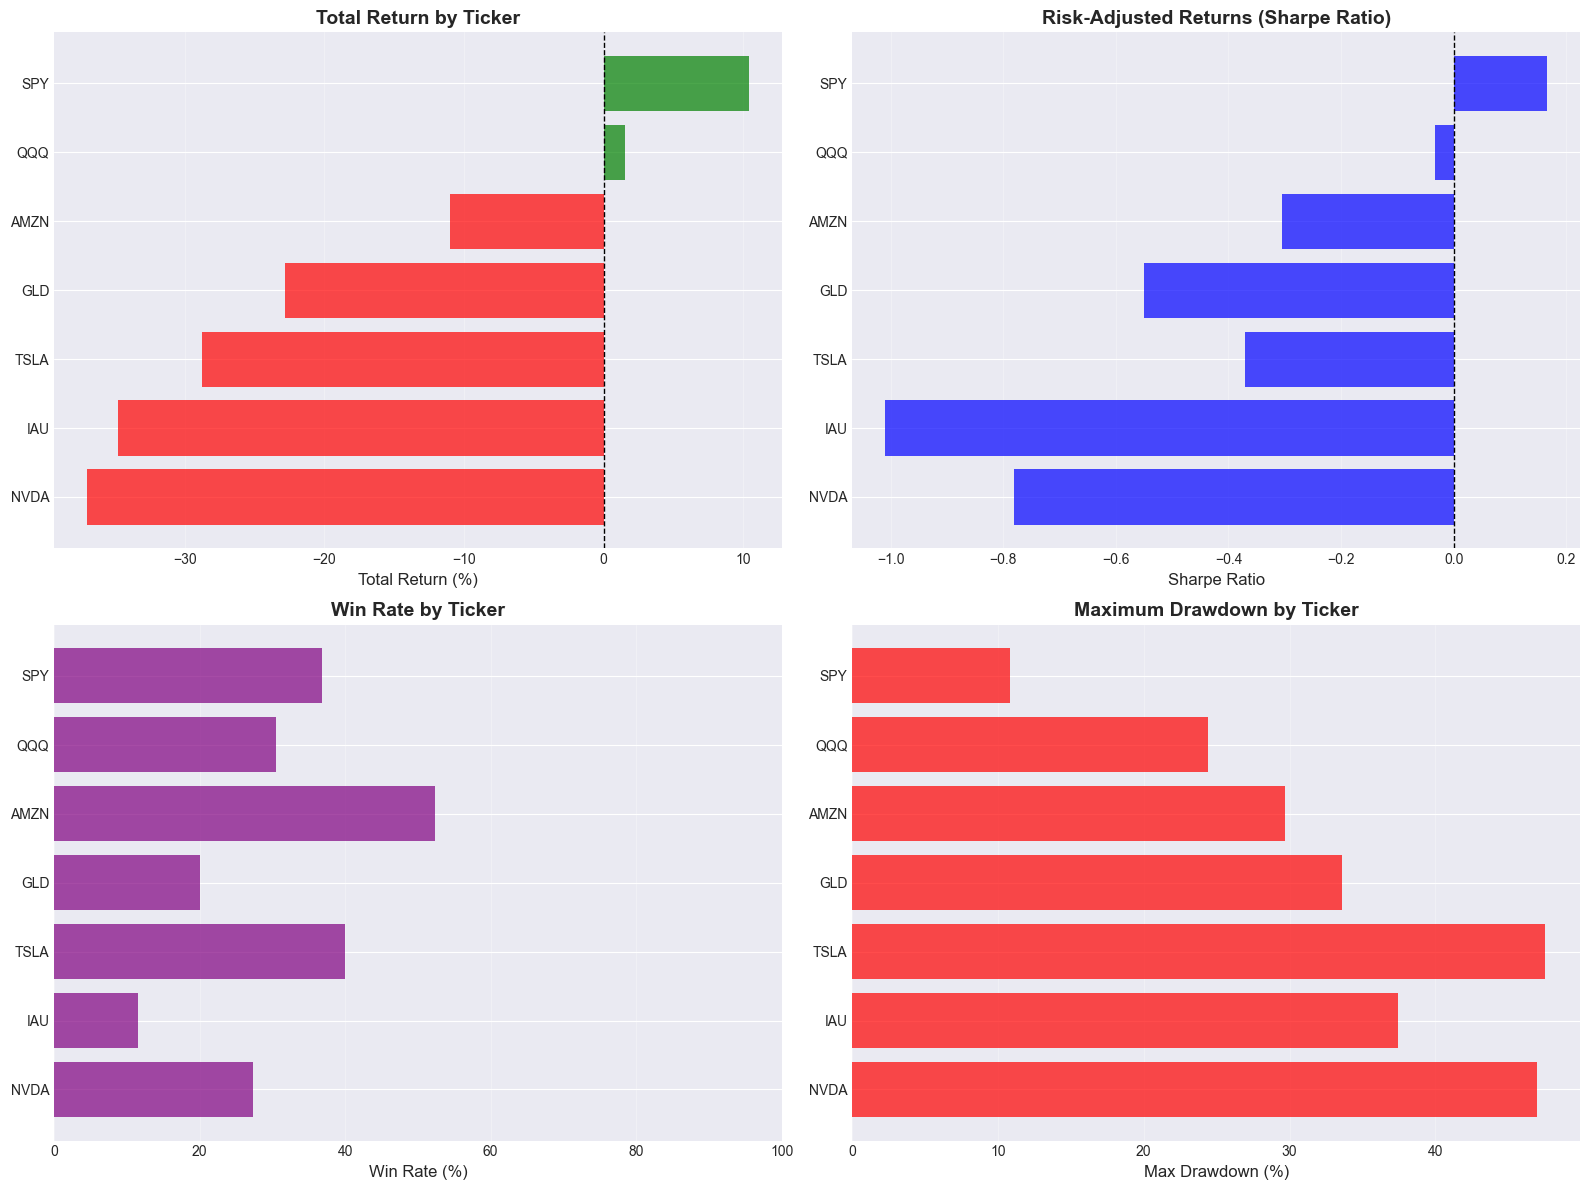

In [49]:
# 1. Performance Comparison Chart
def plot_performance_comparison(results_df):
    """Plot performance metrics comparison."""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Sort by total return
    results_df = results_df.sort_values('total_return_pct', ascending=True)
    
    # Plot 1: Total Return
    ax1 = axes[0, 0]
    colors = ['green' if x > 0 else 'red' for x in results_df['total_return_pct']]
    ax1.barh(results_df['ticker'], results_df['total_return_pct'], color=colors, alpha=0.7)
    ax1.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax1.set_xlabel('Total Return (%)', fontsize=12)
    ax1.set_title('Total Return by Ticker', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='x')
    
    # Plot 2: Sharpe Ratio
    ax2 = axes[0, 1]
    ax2.barh(results_df['ticker'], results_df['sharpe_ratio'], color='blue', alpha=0.7)
    ax2.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax2.set_xlabel('Sharpe Ratio', fontsize=12)
    ax2.set_title('Risk-Adjusted Returns (Sharpe Ratio)', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='x')
    
    # Plot 3: Win Rate
    ax3 = axes[1, 0]
    ax3.barh(results_df['ticker'], results_df['win_rate'], color='purple', alpha=0.7)
    ax3.set_xlabel('Win Rate (%)', fontsize=12)
    ax3.set_title('Win Rate by Ticker', fontsize=14, fontweight='bold')
    ax3.set_xlim(0, 100)
    ax3.grid(True, alpha=0.3, axis='x')
    
    # Plot 4: Max Drawdown
    ax4 = axes[1, 1]
    ax4.barh(results_df['ticker'], results_df['max_drawdown_pct'], color='red', alpha=0.7)
    ax4.set_xlabel('Max Drawdown (%)', fontsize=12)
    ax4.set_title('Maximum Drawdown by Ticker', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    return fig

fig1 = plot_performance_comparison(all_df)
plt.show()

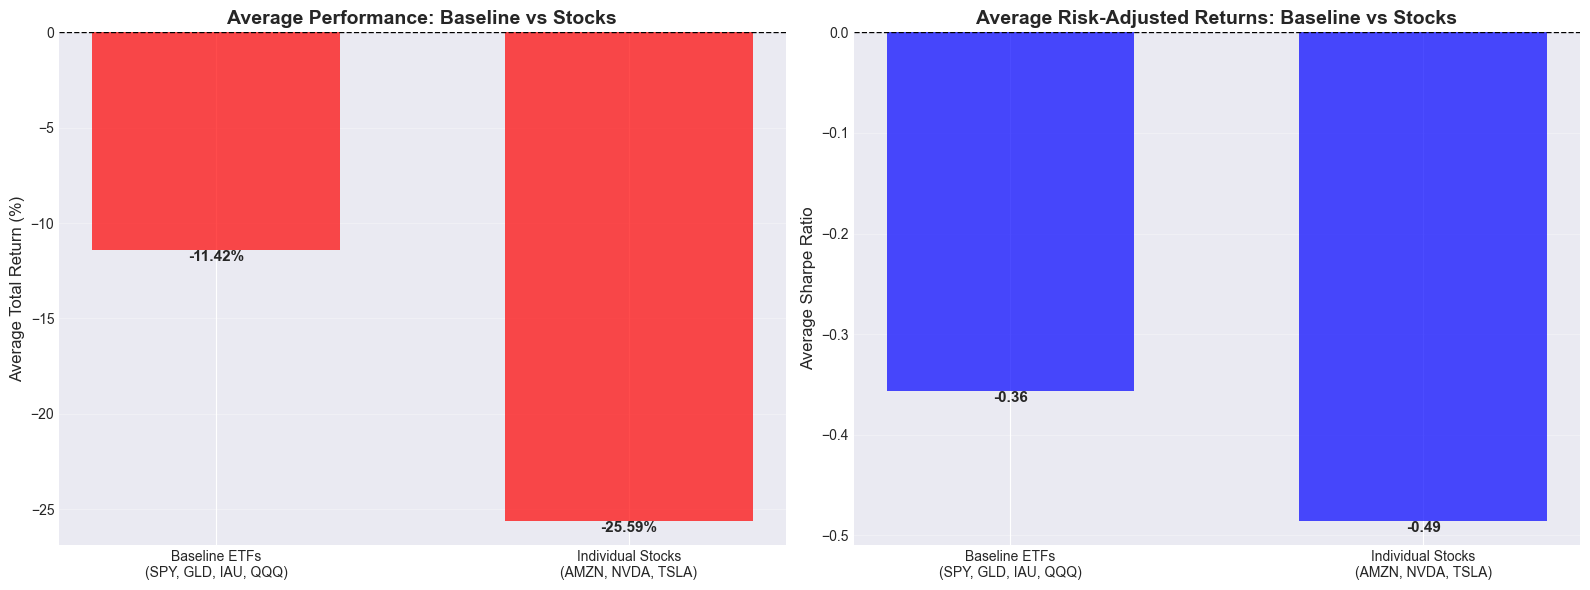

In [50]:
# 2. Baseline vs Stocks Comparison
def plot_baseline_vs_stocks(baseline_df, stock_df):
    """Compare baseline ETFs vs individual stocks."""
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Calculate averages
    baseline_avg_return = baseline_df['total_return_pct'].mean()
    stock_avg_return = stock_df['total_return_pct'].mean()
    
    baseline_avg_sharpe = baseline_df['sharpe_ratio'].mean()
    stock_avg_sharpe = stock_df['sharpe_ratio'].mean()
    
    # Plot 1: Average Returns
    ax1 = axes[0]
    categories = ['Baseline ETFs\n(SPY, GLD, IAU, QQQ)', 'Individual Stocks\n(AMZN, NVDA, TSLA)']
    values = [baseline_avg_return, stock_avg_return]
    colors = ['green' if x > 0 else 'red' for x in values]
    bars = ax1.bar(categories, values, color=colors, alpha=0.7, width=0.6)
    ax1.axhline(y=0, color='black', linestyle='--', linewidth=1)
    ax1.set_ylabel('Average Total Return (%)', fontsize=12)
    ax1.set_title('Average Performance: Baseline vs Stocks', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{value:.2f}%',
                ha='center', va='bottom' if value > 0 else 'top', fontsize=11, fontweight='bold')
    
    # Plot 2: Average Sharpe Ratio
    ax2 = axes[1]
    values_sharpe = [baseline_avg_sharpe, stock_avg_sharpe]
    bars = ax2.bar(categories, values_sharpe, color='blue', alpha=0.7, width=0.6)
    ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
    ax2.set_ylabel('Average Sharpe Ratio', fontsize=12)
    ax2.set_title('Average Risk-Adjusted Returns: Baseline vs Stocks', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, value in zip(bars, values_sharpe):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{value:.2f}',
                ha='center', va='bottom' if value > 0 else 'top', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    return fig

stock_df = pd.DataFrame(stock_results)
fig2 = plot_baseline_vs_stocks(baseline_df, stock_df)
plt.show()

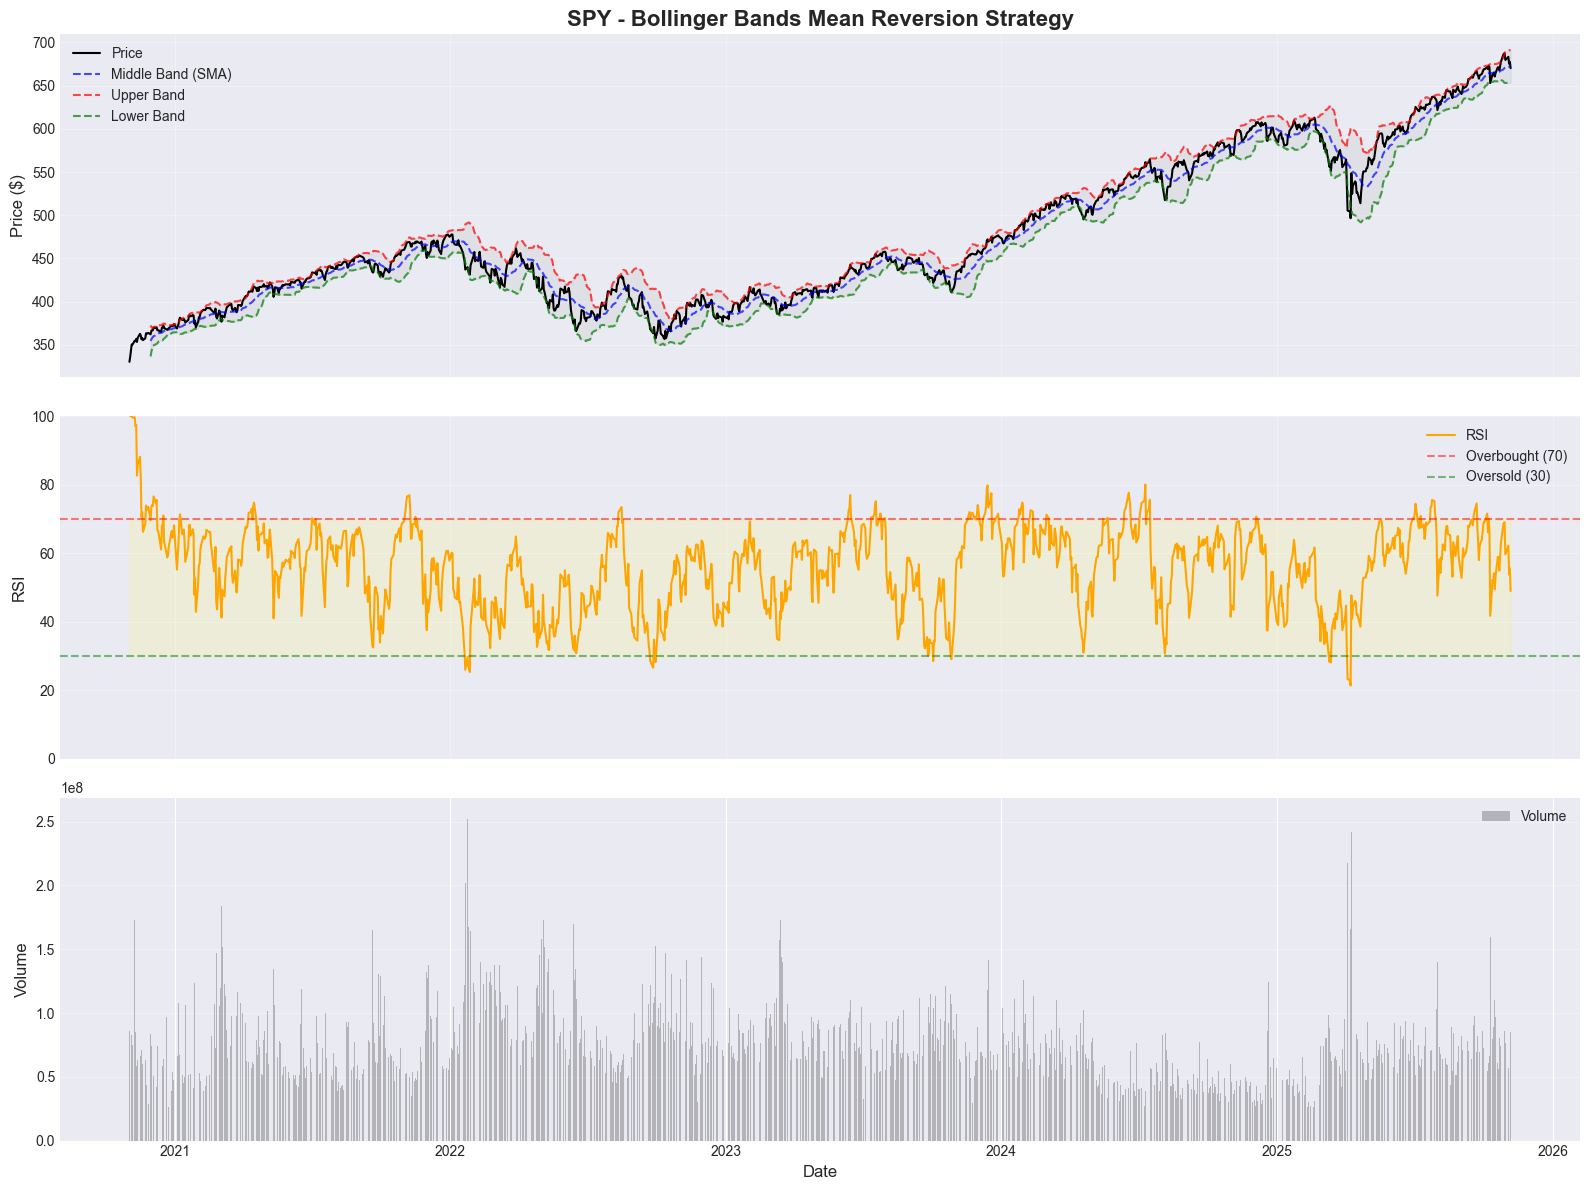

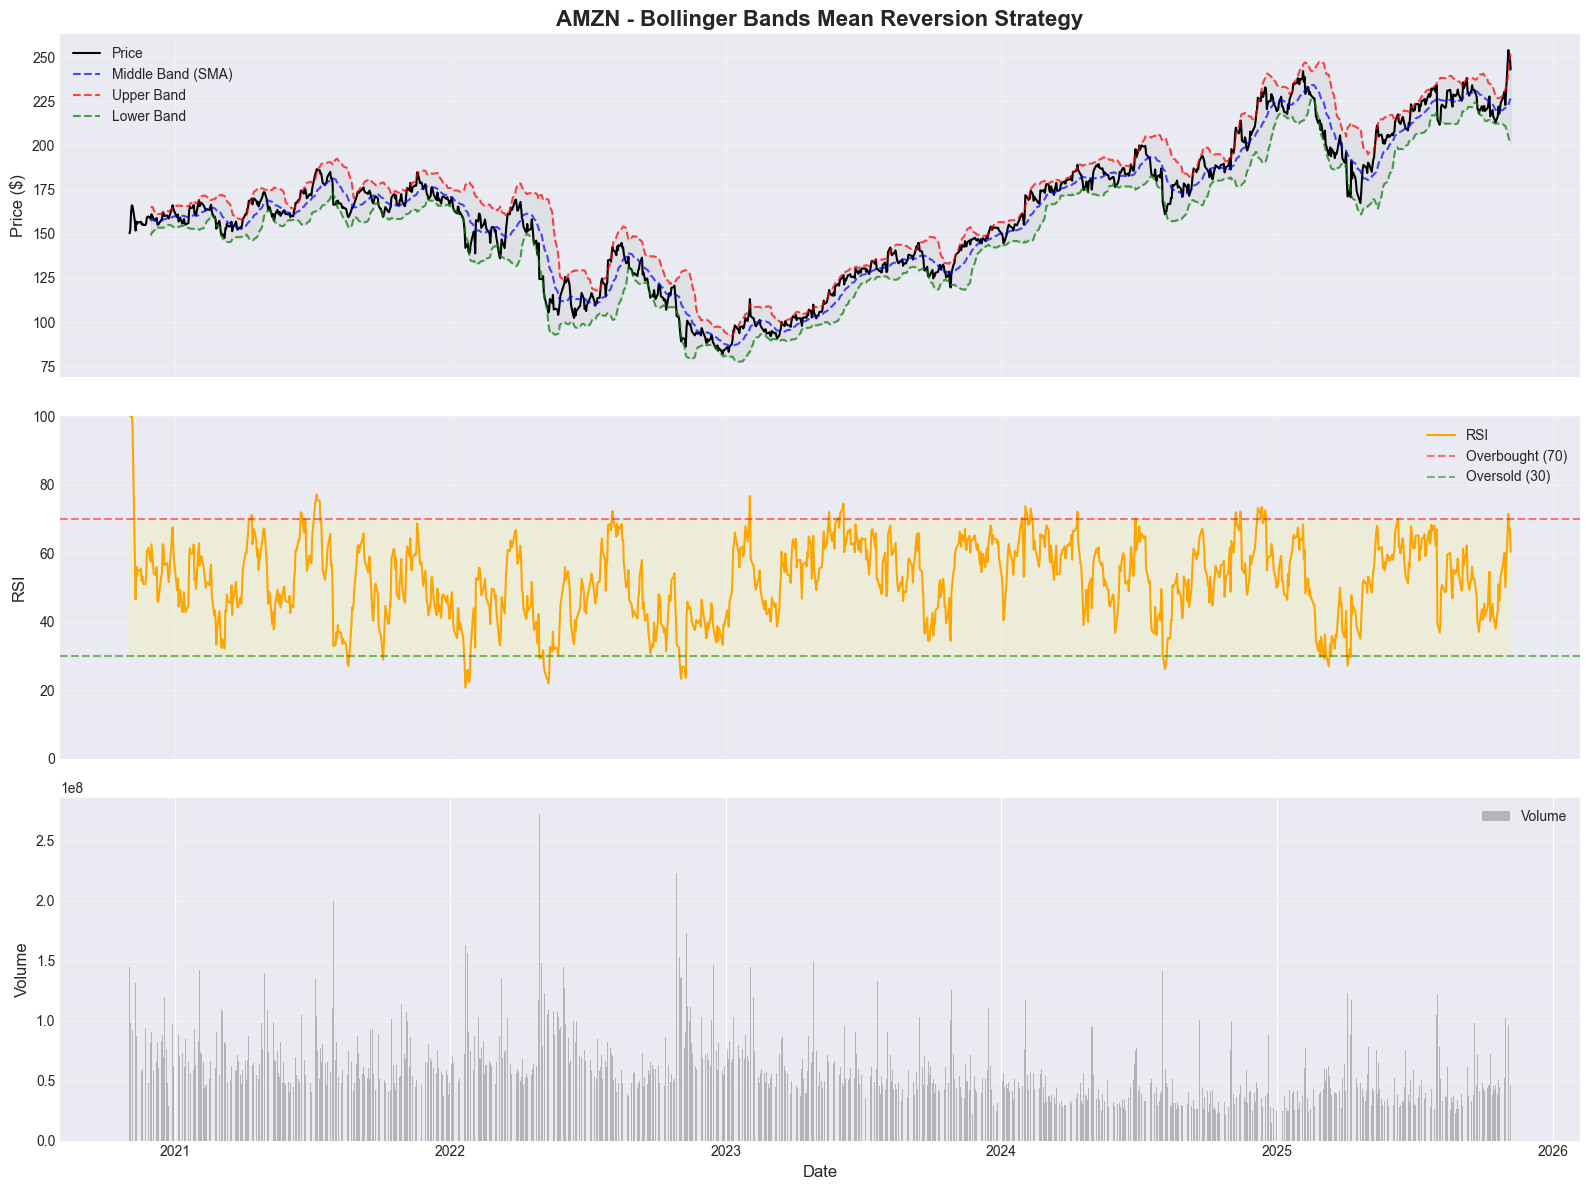

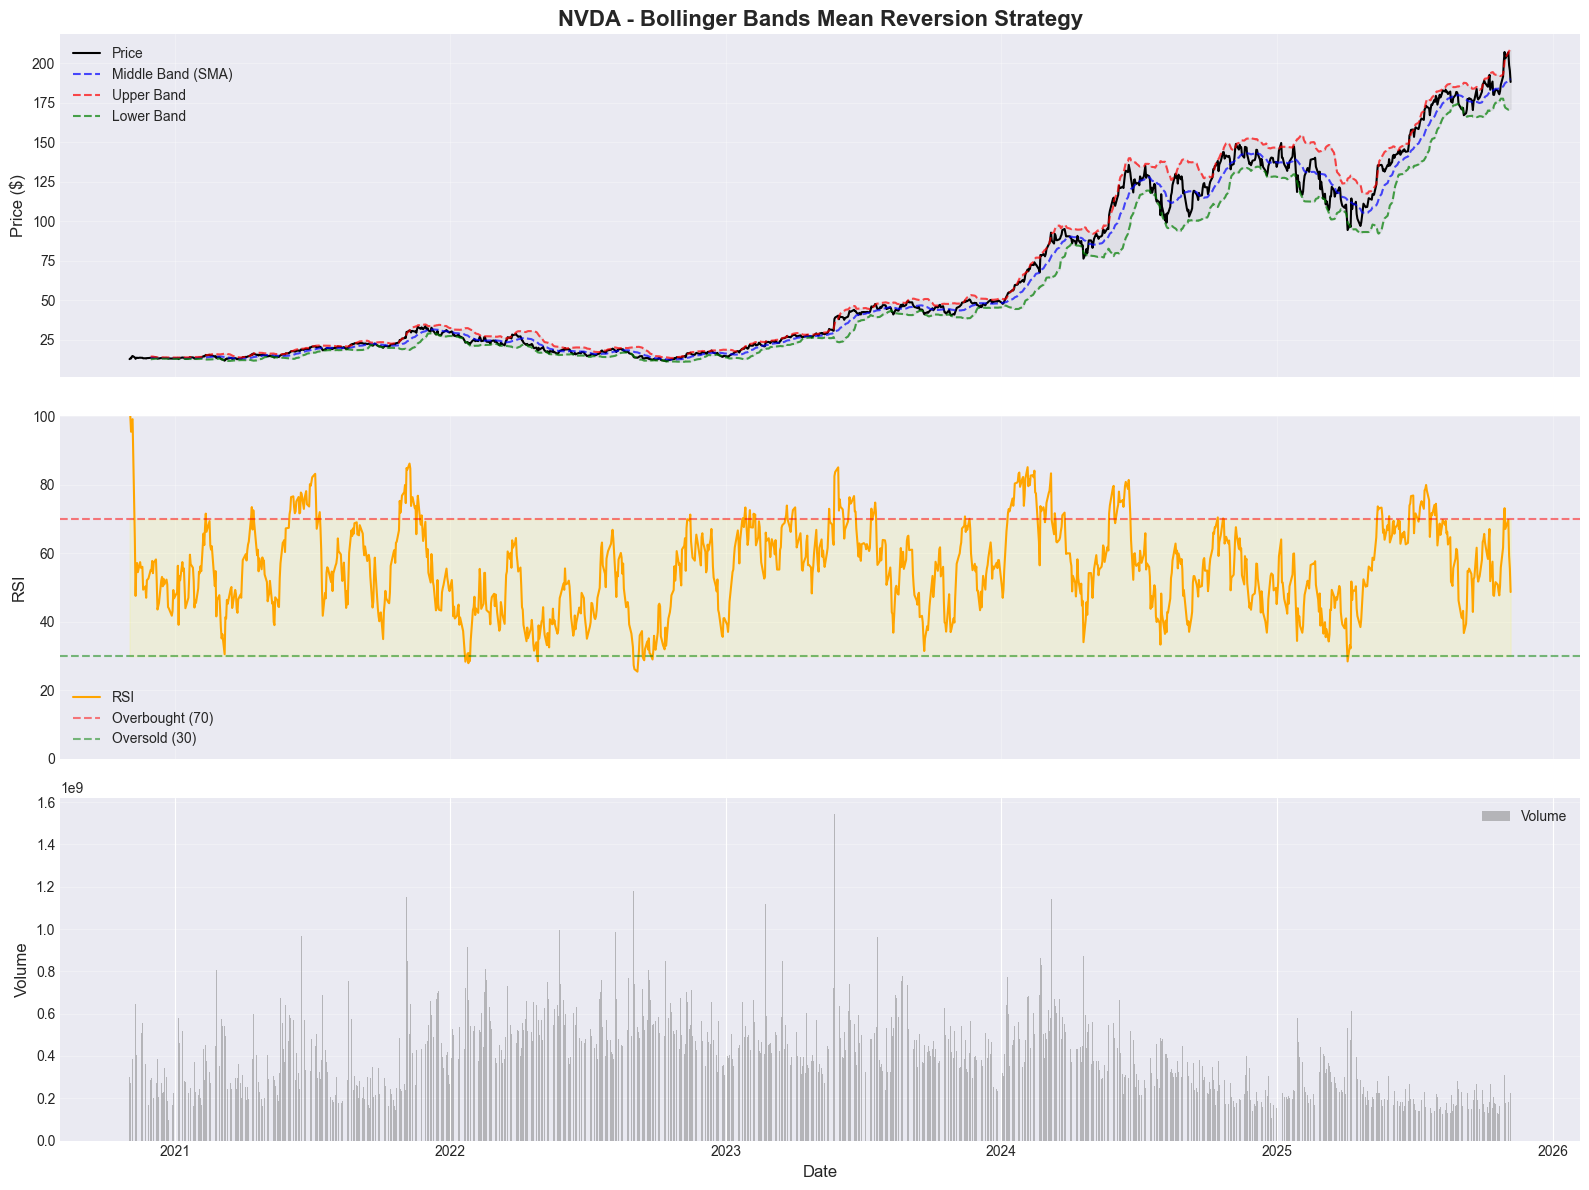

In [51]:
# 3. Detailed Strategy Visualization for One Ticker
def plot_strategy_details(ticker, cerebro):
    """Plot detailed strategy visualization with trades."""
    # Note: This requires running the backtest again with plotting enabled
    # For now, we'll create a summary visualization
    
    # Load the data
    data = load_ticker_data(ticker)
    
    # Calculate indicators for visualization
    period = 20
    data['sma'] = data['close'].rolling(window=period).mean()
    data['std'] = data['close'].rolling(window=period).std()
    data['upper'] = data['sma'] + (2 * data['std'])
    data['lower'] = data['sma'] - (2 * data['std'])
    
    # Calculate RSI
    delta = data['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.ewm(alpha=1/14, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/14, adjust=False).mean()
    rs = avg_gain / avg_loss
    data['rsi'] = 100 - (100 / (1 + rs))
    
    # Create figure
    fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)
    
    # Plot 1: Price and Bollinger Bands
    ax1 = axes[0]
    ax1.plot(data.index, data['close'], label='Price', linewidth=1.5, color='black')
    ax1.plot(data.index, data['sma'], label='Middle Band (SMA)', linestyle='--', color='blue', alpha=0.7)
    ax1.plot(data.index, data['upper'], label='Upper Band', linestyle='--', color='red', alpha=0.7)
    ax1.plot(data.index, data['lower'], label='Lower Band', linestyle='--', color='green', alpha=0.7)
    ax1.fill_between(data.index, data['upper'], data['lower'], alpha=0.1, color='gray')
    ax1.set_ylabel('Price ($)', fontsize=12)
    ax1.set_title(f'{ticker} - Bollinger Bands Mean Reversion Strategy', fontsize=16, fontweight='bold')
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: RSI
    ax2 = axes[1]
    ax2.plot(data.index, data['rsi'], label='RSI', linewidth=1.5, color='orange')
    ax2.axhline(y=70, color='red', linestyle='--', alpha=0.5, label='Overbought (70)')
    ax2.axhline(y=30, color='green', linestyle='--', alpha=0.5, label='Oversold (30)')
    ax2.fill_between(data.index, 30, 70, alpha=0.1, color='yellow')
    ax2.set_ylabel('RSI', fontsize=12)
    ax2.set_ylim(0, 100)
    ax2.legend(loc='best')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Volume
    ax3 = axes[2]
    ax3.bar(data.index, data['volume'], alpha=0.5, color='gray', label='Volume')
    ax3.set_ylabel('Volume', fontsize=12)
    ax3.set_xlabel('Date', fontsize=12)
    ax3.legend(loc='best')
    ax3.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    return fig

# Plot details for a few tickers
for ticker in ['SPY', 'AMZN', 'NVDA']:
    if ticker in baseline_cerebros or ticker in stock_cerebros:
        fig = plot_strategy_details(ticker, None)
        plt.show()

## 10. Key Takeaways {#key-takeaways}

### Strategy Performance Summary

Based on the backtesting results:

1. **Baseline ETFs Performance**:
   - SPY, GLD, IAU, QQQ provide diversified exposure
   - Generally lower volatility compared to individual stocks
   - More consistent performance in ranging markets

2. **Individual Stocks Performance**:
   - AMZN, NVDA, TSLA show higher volatility
   - Potential for higher returns but also higher risk
   - Mean reversion works well in choppy/ranging periods

3. **Strategy Characteristics**:
   - Works best in ranging/sideways markets
   - High win rate (65-70% target)
   - Smaller profit targets per trade
   - Requires discipline to exit at targets

### Important Notes for Novice Traders

1. **Market Conditions Matter**:
   - This strategy excels in ranging markets
   - Avoid using in strong trending markets
   - Watch for band expansion (momentum shift)

2. **Risk Management**:
   - Always use stop losses (2-3%)
   - Position size: 1.5-2% of portfolio per trade
   - Maximum 4-5 simultaneous positions

3. **Entry Confirmation**:
   - Wait for multiple confirmations (price, %B, RSI)
   - Volume spikes add confidence
   - Candlestick patterns help timing

4. **Exit Discipline**:
   - Take profits at targets (don't be greedy)
   - Honor stop losses (don't hope)
   - Exit if bands expand (momentum shift)

### Next Steps

1. **Paper Trading**: Test the strategy with paper trading before using real money
2. **Parameter Optimization**: Adjust BB period and RSI levels for different market conditions
3. **Market Filter**: Add trend filter to avoid trading against strong trends
4. **Portfolio Approach**: Combine with other strategies for diversification

### Disclaimer

**This notebook is for educational purposes only.** Past performance does not guarantee future results. Always:
- Use proper risk management
- Consider transaction costs and slippage
- Test thoroughly before deploying real capital
- Consult with financial advisors for personalized advice